# Прогноз оттока клиентов

Оператору связи «Ниединогоразрыва.ком» необходимо разработать модель, которая поможет компании спрогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Цель проекта

- Построить модель с предельно большим значением метрики AUC-ROC.
- Проверить модель на тестовой выборке. Необходимо довести метрику до значения не ниже 0.87.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Информация о договорах актуальна на 1 февраля 2020.

### Описание данных

**Таблица contract — информация о договоре:**

- customerID - уникальный идентификатор пользователя;
- BeginDate - дата подписания контракта;
- EndDate - дата расторжения контракта;
- Type - тип оплаты;
- PaperlessBilling - безналичный расчет;
- PaymentMethod - способ оплаты;
- MonthlyCharges - ежемесячные платежи;
- TotalCharges - общая сумма платежей.

**Таблица personal — персональные данные клиента:**

- customerID - уникальный идентификатор пользователя;
- gender - пол;
- SeniorCitizen - наличие пенсионного статуса;
- Partner - наличие супруга(и);
- Dependents - наличие иждивенцев.

**Таблица internet — информация об интернет-услугах:**

- customerID - уникальный идентификатор пользователя
- InternetService - интернет-сервис (способ подключения к интернету);
- OnlineSecurity - блокировка небезопасных сайтов;
- OnlineBackup - хранилище файлов для резервного копирования данных;
- DeviceProtection - антивирус;
- TechSupport - тех поддержка;
- StreamingTV - стриминговое телевидение;
- StreamingMovies - каталог фильмов.

**Таблица phone — информация об услугах телефонии:**
- customerID - уникальный идентификатор пользователя
- MultipleLines - наличие возможности ведения параллельных линий во время звонка.


## План работы

- Импорт данных и их начальная предобработка;
- Исследовательский анализ данных;
- Объединение данных;
- Разбиение данных на выборки;
- Выбор модели машинного обучения;
- Обучение и тестирование модели;
- Общий вывод;
- Отчет.

## Импорт данных. Предобработка данных

In [1]:
# импортируем необходимые библиотеки

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
import xgboost


from catboost import CatBoostClassifier, Pool, cv
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, StratifiedKFold, GridSearchCV, cross_validate, KFold

import warnings
warnings.simplefilter("ignore")

from numpy.random import RandomState
STATE = RandomState(80822)


In [2]:
# загрузим данные

try:
    contract = pd.read_csv('contract.csv')
    personal = pd.read_csv('personal.csv')
    internet = pd.read_csv('internet.csv')
    phone = pd.read_csv('phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
# таблица с данными по контрактам

display(contract.info())
print()

display(f'Дубликатов в таблице contract: {contract.duplicated().sum()}')
print()

display(contract.describe())
print()

display(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

'Дубликатов в таблице contract: 0'

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [4]:
# таблица с данными клиентов

display(personal.info())
print()

display(f'Дубликатов в таблице personal: {personal.duplicated().sum()}')
print()

display(personal.describe())
print()

display(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

'Дубликатов в таблице personal: 0'

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [5]:
# таблица с данными по интернет-услугам 

display(internet.info())
print()

display(f'Дубликатов в таблице internet: {internet.duplicated().sum()}')
print()

display(internet.describe())
print()

display(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

'Дубликатов в таблице internet: 0'

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [6]:
# таблица с данными по интернет-услугам 

display(phone.info())
print()

display(f'Дубликатов в таблице phone: {phone.duplicated().sum()}')
print()

display(phone.describe())
print()

display(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

'Дубликатов в таблице phone: 0'

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


**Вывод**

Для работы нам предоставлены 4 таблицы с данными.

1. contract - содержит данные о договорах (типы и даты контрактов, способах оплаты и суммах платежей)
- состоит из 7 043 строк и 8 столбцов;
- тип данных у всех столбцов object, кроме MonthlyCharge (float), хотя в столбце TotalCharges должен быть int64, а в столбцах с датами - datetime;
- дубликатов и пропусков не выявлено;
- статистические данные показывают, что в среднем ежемесячный платеж составляет 64.76, минамыльный - 18.25 и максимальный - 118.75.

2. personal - содержит данные о клиентах (пол, наличие пенсионного статуса, супруга(и) и иждивенцев)
- состоит из 7 043 строк и 5 столбцов;
- тип данных у всех столбцов object, кроме SeniorCitizen (int64);
- дубликатов и пропусков не выявлено.

3. internet - содержит данные о подключенных дополнительных услугах (способ подключения к интернету, блокировка сайтов, хранилище файлов, антивирус, тех поддержка, телевидиние и фильмы)
- состоит из 5 517 строк и 8 столбцов;
- тип данных у всех столбцов object;
- дубликатов и пропусков нет;
- статистические данные показывают, что чуть больше половины используют для подключения Fiber optic, также чуть больше половины клиентов не пользуются дополнительными услугами.

4. phone - содержит данные о наличии возможности ведения параллельных линий во время звонка
- состоит из 6 361 строк и 2 столбцов;
- тип данных у всех столбцов object;
- дубликатов и пропусков нет;
- статистические данные показывают, что чуть больше половины не имеют возможности ведения параллельных линий во время звонка.

Все таблицы имеют уникальный идентификатор пользователя.

На начальном этапе (для упрощения работы с данными) мы можем внести следующие изменения:
- привести наименования столбцов к одному стилю;
- привести все данные к одному регистру (например к нижнему);
- изменить типы данных в таблице contract, так как почти везде стоит тип данных object.

Также нужно добавить столбец с классами для таблицы contract, определяющими отток клиентов - определим классы как True и False.

## Предобработка данных

In [7]:
# приведем наименования столбцов к одному стилу

contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges']
personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']
internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup', 
                    'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
phone.columns = ['customer_id', 'multiple_lines']

In [8]:
# изменим регистр в данных на нижний
# напишем функцию

def lower_register(table):
    '''Функция получает на вход таблицу
    и меняет регистр у всех столбцов кроме customer_id'
    и только у данных с типом "object".
    '''
    for col in table:
        if col != 'customer_id' and table[col].dtype == 'object':
            table[col] = table[col].str.lower()
    return

lower_register(contract)
lower_register(personal)
lower_register(internet)
lower_register(phone)

In [9]:
# выведем таблицы после внесения изменений

print('После внесения изменений получаем таблицы следующего вида:')
print()

display(contract)
print()

display(personal)
print()

display(internet)
print()

display(phone)
print()

После внесения изменений получаем таблицы следующего вида:



,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,no,month-to-month,yes,electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,no,one year,no,mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,month-to-month,yes,mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,month-to-month,yes,electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,no,one year,yes,mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,no,one year,yes,credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,no,month-to-month,yes,electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,month-to-month,yes,mailed check,74.40,306.6


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,female,0,yes,no
1,5575-GNVDE,male,0,no,no
2,3668-QPYBK,male,0,no,no
3,7795-CFOCW,male,0,no,no
4,9237-HQITU,female,0,no,no
...,...,...,...,...,...
7038,6840-RESVB,male,0,yes,yes
7039,2234-XADUH,female,0,yes,yes
7040,4801-JZAZL,female,0,yes,yes
7041,8361-LTMKD,male,1,yes,no


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,dsl,no,yes,no,no,no,no
1,5575-GNVDE,dsl,yes,no,yes,no,no,no
2,3668-QPYBK,dsl,yes,yes,no,no,no,no
3,7795-CFOCW,dsl,yes,no,yes,yes,no,no
4,9237-HQITU,fiber optic,no,no,no,no,no,no
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,dsl,yes,no,yes,yes,yes,yes
5513,2234-XADUH,fiber optic,no,yes,yes,no,yes,yes
5514,4801-JZAZL,dsl,yes,no,no,no,no,no
5515,8361-LTMKD,fiber optic,no,no,no,no,no,no


,customer_id,multiple_lines
0,5575-GNVDE,no
1,3668-QPYBK,no
2,9237-HQITU,no
3,9305-CDSKC,yes
4,1452-KIOVK,yes
...,...,...
6356,2569-WGERO,no
6357,6840-RESVB,yes
6358,2234-XADUH,yes
6359,8361-LTMKD,yes


In [10]:
# изменим типы данных у таблицы contract

contract['total_charges'] = pd.to_numeric(contract.total_charges, errors='coerce')
contract['begin_date'] = pd.to_datetime(contract.begin_date, errors='coerce')

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


- **После изменения типа данных у нас появились пропуски.**

In [11]:
# проверим, в каких строках отсутствуют данные по total_charges

table = contract[contract['total_charges'].isnull()]
table

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,no,two year,yes,bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,no,two year,no,mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,no,two year,no,mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,no,two year,no,mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,no,two year,no,credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,no,two year,no,mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,no,two year,no,mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,no,two year,no,mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,no,one year,yes,mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,no,two year,no,mailed check,73.35,NaN


- **Так как пропусков у нас немного (11), мы вывели все значения в отдельную таблицу. Можно заметить, что даты расторжения договора отутствуют и тип договора двухгодичный. Учитывая, что информация о договорах актуальна на 1 февраля 2020, делаем вывод, что клиенты еще не произвели оплату, либо данные не обновились на момент выгрузки. В таком случае мы можем заменить эти пропуски на произведение месячной оплаты на количество месяцев, согласно условиям договора.**

In [12]:
# проверим даты заключения контрактов
# сгруппируем данные по датам и посчитаем еоличество клиентов

table_pvt = table.pivot_table(index='begin_date', values='customer_id', aggfunc='count')
display(table_pvt)

,customer_id
begin_date,
2020-02-01,11


- **Дата заключения контракта у всех клиентов с пропущенными значениями по общим платежам одна**

In [13]:
# заменим пропуски
# пока что заменим пропуски на общую сумму по месяцам учитывая тип оплаты

contract['total_charges'] = contract['total_charges'].fillna(contract['monthly_charges']*24)

In [14]:
# добавим столбец с классами

contract['churn_classification'] = np.where(contract.end_date == 'no', 0, 1)

contract

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn_classification
0,7590-VHVEG,2020-01-01,no,month-to-month,yes,electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,no,one year,no,mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,month-to-month,yes,mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,month-to-month,yes,electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,no,one year,yes,mailed check,84.80,1990.50,0
7039,2234-XADUH,2014-02-01,no,one year,yes,credit card (automatic),103.20,7362.90,0
7040,4801-JZAZL,2019-03-01,no,month-to-month,yes,electronic check,29.60,346.45,0
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,month-to-month,yes,mailed check,74.40,306.60,1


**Вывод**

В процессе предобработки данных мы:
- изменили стиль наименования столбцов;
- поменяли типы данных в столбцах total_charges и begin_date;
- привели все данные к нижнему регистру;
- заполнили пропуски в total_charges;
- добавили столбец с классами для целевого признака.

## Исследовательский анализ данных

- Объединим таблицы. Подготовим данные к анализу.

In [15]:
# объединим таблицы в одну

data = contract.merge(personal, on=['customer_id'], how='outer') \
                        .merge(internet, on=['customer_id'], how='outer') \
                            .merge(phone, on=['customer_id'], how='outer')

data

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn_classification,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,no,month-to-month,yes,electronic check,29.85,29.85,0,female,...,yes,no,dsl,no,yes,no,no,no,no,NaN
1,5575-GNVDE,2017-04-01,no,one year,no,mailed check,56.95,1889.50,0,male,...,no,no,dsl,yes,no,yes,no,no,no,no
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,month-to-month,yes,mailed check,53.85,108.15,1,male,...,no,no,dsl,yes,yes,no,no,no,no,no
3,7795-CFOCW,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1840.75,0,male,...,no,no,dsl,yes,no,yes,yes,no,no,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,month-to-month,yes,electronic check,70.70,151.65,1,female,...,no,no,fiber optic,no,no,no,no,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,no,one year,yes,mailed check,84.80,1990.50,0,male,...,yes,yes,dsl,yes,no,yes,yes,yes,yes,yes
7039,2234-XADUH,2014-02-01,no,one year,yes,credit card (automatic),103.20,7362.90,0,female,...,yes,yes,fiber optic,no,yes,yes,no,yes,yes,yes
7040,4801-JZAZL,2019-03-01,no,month-to-month,yes,electronic check,29.60,346.45,0,female,...,yes,yes,dsl,yes,no,no,no,no,no,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,month-to-month,yes,mailed check,74.40,306.60,1,male,...,yes,no,fiber optic,no,no,no,no,no,no,yes


**Вывод**

После слияния таблиц появились пропуски и только в столбцах по доп услугам. Скорей всего клиенты не пользовались этими услугами. Здесь мы можем заменить все NaN на 'no'.

In [16]:
# еще раз проверим пропуски
# посчитаем разницу между талицами и сравним ее с количеством пропусков

display(data.isna().sum())

print(f'Разница в количестве уникальных клиентов между таблицами contract (personal) и internet: {contract.shape[0] - internet.shape[0]}')
print(f'Разница в количестве уникальных клиентов между таблицами contract (personal) и phone: {contract.shape[0] - phone.shape[0]}')


customer_id                0
begin_date                 0
end_date                   0
type                       0
paperless_billing          0
payment_method             0
monthly_charges            0
total_charges              0
churn_classification       0
gender                     0
senior_citizen             0
partner                    0
dependents                 0
internet_service        1526
online_security         1526
online_backup           1526
device_protection       1526
tech_support            1526
streaming_tv            1526
streaming_movies        1526
multiple_lines           682
dtype: int64

Разница в количестве уникальных клиентов между таблицами contract (personal) и internet: 1526
Разница в количестве уникальных клиентов между таблицами contract (personal) и phone: 682


In [17]:
# заменим все пропущенные значения в таблице data на 'no'

data = data.fillna('no', axis=0)

data.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
churn_classification    0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
multiple_lines          0
dtype: int64

**Избавились от пропусков - можно подробнее изучить данные**

- Изучим корреляцию.

In [18]:
data.corr()

,monthly_charges,total_charges,churn_classification,senior_citizen
monthly_charges,1.000000,0.651248,0.193356,0.220173
total_charges,0.651248,1.000000,-0.198834,0.102756
churn_classification,0.193356,-0.198834,1.000000,0.150889
senior_citizen,0.220173,0.102756,0.150889,1.000000


In [19]:
# посмотрим на взаимосвязь данных
# исключим customer_id и сохраним данные в отдельную переменную

df_corr = data.drop('customer_id', axis=1)
df_corr.phik_matrix()


interval columns not set, guessing: ['monthly_charges', 'total_charges', 'churn_classification', 'senior_citizen']


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn_classification,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
begin_date,1.000000,0.584146,0.766249,0.081447,0.456389,0.421886,0.819094,0.495211,0.011268,0.050862,0.473514,0.208564,0.192197,0.403560,0.445583,0.456002,0.399506,0.359784,0.371863,0.428109
end_date,0.584146,1.000000,0.357462,0.156832,0.212169,0.319733,0.250687,1.000000,0.000000,0.123124,0.121753,0.133425,0.288479,0.139392,0.068364,0.051336,0.134227,0.050373,0.047014,0.034949
type,0.766249,0.357462,1.000000,0.106860,0.277462,0.388444,0.506168,0.251639,0.000000,0.086231,0.179736,0.147680,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.065498
paperless_billing,0.081447,0.156832,0.106860,1.000000,0.370495,0.467812,0.205404,0.295754,0.000000,0.242133,0.013218,0.172593,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.252972
payment_method,0.456389,0.212169,0.277462,0.370495,1.000000,0.399526,0.350468,0.449125,0.000000,0.292725,0.243008,0.224903,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.339313
monthly_charges,0.421886,0.319733,0.388444,0.467812,0.399526,1.000000,0.762966,0.360050,0.008175,0.304985,0.203545,0.184366,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.675883
total_charges,0.819094,0.250687,0.506168,0.205404,0.350468,0.762966,1.000000,0.280131,0.000000,0.148482,0.423344,0.116810,0.508300,0.545138,0.655835,0.672001,0.566545,0.660332,0.666439,0.605939
churn_classification,0.495211,1.000000,0.251639,0.295754,0.449125,0.360050,0.280131,1.000000,0.000000,0.233432,0.232930,0.253936,0.196202,0.264580,0.126973,0.101516,0.254615,0.096865,0.093923,0.059581
gender,0.011268,0.000000,0.000000,0.000000,0.000000,0.008175,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000
senior_citizen,0.050862,0.123124,0.086231,0.242133,0.292725,0.304985,0.148482,0.233432,0.000000,1.000000,0.016992,0.324576,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.221313


**Взаимосвязь оттока клиентов имеет слабую зависимость от остальных признаков, которые у нас есть. Выделяется только два признака, которые немного больше влияют на отток - это дата заключения контракта и тип оплаты.**

**Если изучить всю матрицу, можно выделить несколько моментов:**
- **Ежемесячные платежи и сумма всех платежей - чем выше оплата в месяц, тем выше общая сумма. Также ежемесячные платежи имеют зависимость от доп.услуг, чего не скажешь про суммы общих платежей;**
- **Даты подписания коррелируют с общими суммами и типом оплаты;**
- **Слабая зависимость заметна между наличием супругов и иждивенцев;**
- **Также по доп.услугам - ТВ и фильмы коррелируют между собой;**
- **Столбец с датой расторжения сильно коррелирует с целевым признаком.**

- Проверим баланс классов

,
churn_classification,
0,5174
1,1869


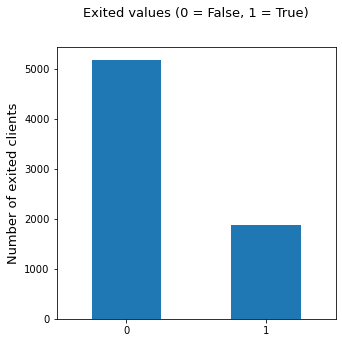

In [20]:
# посмотрим на соотношение классов в целом

exited_clients = data.pivot_table(index='churn_classification', values='customer_id', aggfunc='count')
exited_clients.columns = ['']
display(exited_clients)

print()
ax = data['churn_classification'].value_counts().plot(kind='bar', figsize=(5, 5), fontsize=10)
ax.set_title('Exited values (0 = False, 1 = True)', size=13, pad=30)
ax.set_ylabel('Number of exited clients', fontsize=13)
plt.xticks(rotation=0)

plt.show()

**Ушедших клиентов почти в три раза меньше. Необходимо будет учесть дисбаланс классов при обучении моделей.**

- Изучим распределения оплат

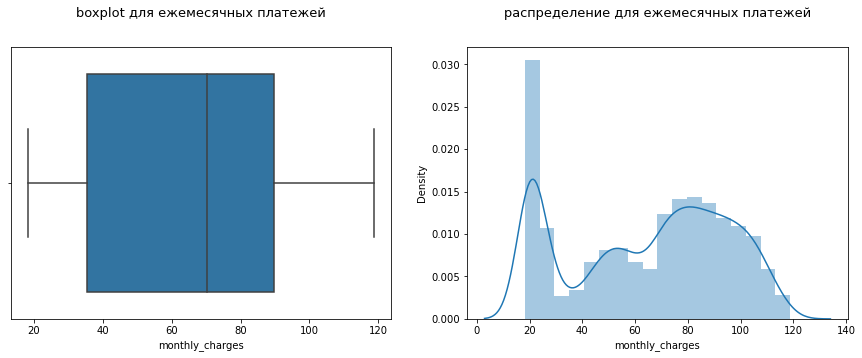

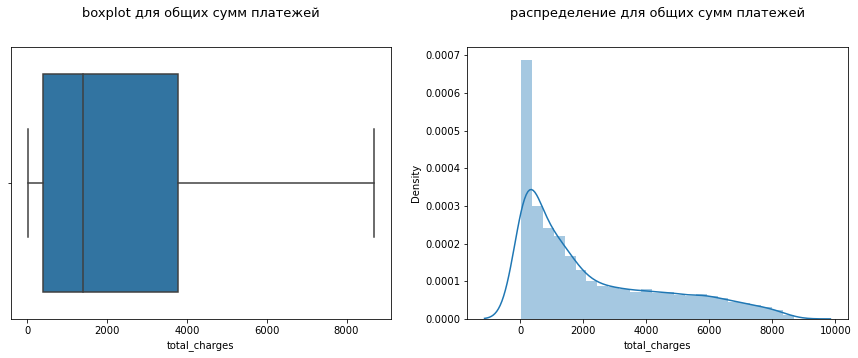

In [21]:
# проверим выбросы и распределение 
# для платежей

monthly = data['monthly_charges']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_title('boxplot для ежемесячных платежей', size=13, pad=30)
ax2.set_title('распределение для ежемесячных платежей', size=13, pad=30)
sns.boxplot(monthly, ax=ax1)
sns.distplot(monthly, ax=ax2)
plt.show()


total = data['total_charges']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_title('boxplot для общих сумм платежей', size=13, pad=30)
ax2.set_title('распределение для общих сумм платежей', size=13, pad=30)
sns.boxplot(total, ax=ax1)
sns.distplot(total, ax=ax2)
plt.show()


- **Выбросов по платежам не обнаружено.**
- **По графику для ежемесячных платежей можно предположить, что большая часть клиентов не преобретает дополнительные услуги, так как суммы платежей примерно от 20.00 до 30.00 имеют плотность выше. А график для общих сумм наводит на мысль, что клиентов с крупными платежами меньше и они дольше пользовались услугами. Проверим это ниже.**

### Посмотрим на срезы данных.

- Проверим, как условия договора влияют на отток клиентов. Построим сводные таблицы и графики к ним. Так как данных много, сделаем все в несколько этапов поделив таблицу на четыре части.

In [22]:
# для начала выделим те столбцы, в которых находятся нужные нам данные
# для удобства создадим четыре списка

contract_cols = ['type', 'paperless_billing', 'payment_method']
personal_cols = ['gender', 'senior_citizen', 'partner', 'dependents']
add_cols_1 = ['internet_service', 'online_security', 'online_backup', 'device_protection']
add_cols_2 = ['tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

# напишем функцию

def func_pvt(table, columns):
    """ 
    Функция принимает на вход таблицу, 
    создает сводную по заданным столбцам (в списке) и выводит на эеран эту сводную.
    Далее строятся графики для каждого столбца из списка.
    
    """
    # задаем параметры для графиков (размер и количество)
    fig, ax = plt.subplots(1, len(columns), figsize=(20, 5))
    
    # создаем цикл для столбцов группировки и их графиков
    for i, j in zip(list(columns), ax):
        tab_pvt = table.pivot_table(index=['churn_classification', i], values='customer_id', aggfunc='count')\
            .reset_index().rename_axis(None, axis=1)
        display(tab_pvt)

        sns.barplot(x=i, y='customer_id', ci=0, hue='churn_classification', data=tab_pvt, ax=j)
        plt.xticks(rotation=45)
        
    return

,churn_classification,type,customer_id
0,0,month-to-month,2220
1,0,one year,1307
2,0,two year,1647
3,1,month-to-month,1655
4,1,one year,166
5,1,two year,48


,churn_classification,paperless_billing,customer_id
0,0,no,2403
1,0,yes,2771
2,1,no,469
3,1,yes,1400


,churn_classification,payment_method,customer_id
0,0,bank transfer (automatic),1286
1,0,credit card (automatic),1290
2,0,electronic check,1294
3,0,mailed check,1304
4,1,bank transfer (automatic),258
5,1,credit card (automatic),232
6,1,electronic check,1071
7,1,mailed check,308


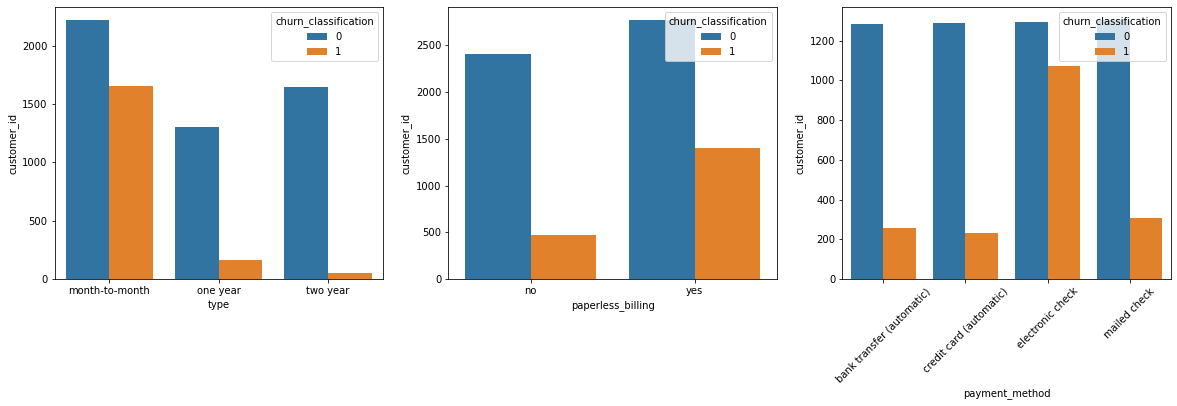

In [23]:
func_pvt(data, contract_cols)

- **По графику видно, что клиентов, оплачивающих услуги помесячно, больше. А клиентов, которые предпочитают оплачивать сразу за год или за два года, почти равное количество. Также ушедших клиентов, которые заключили годичный и двухгодичный контракты, очень мало.**
- **Если рассматривать именно отток клиентов, то сильно выделяются те клиенты, которые оплачивали услуги помесячно и электронными чеками.**

,churn_classification,gender,customer_id
0,0,female,2549
1,0,male,2625
2,1,female,939
3,1,male,930


,churn_classification,senior_citizen,customer_id
0,0,0,4508
1,0,1,666
2,1,0,1393
3,1,1,476


,churn_classification,partner,customer_id
0,0,no,2441
1,0,yes,2733
2,1,no,1200
3,1,yes,669


,churn_classification,dependents,customer_id
0,0,no,3390
1,0,yes,1784
2,1,no,1543
3,1,yes,326


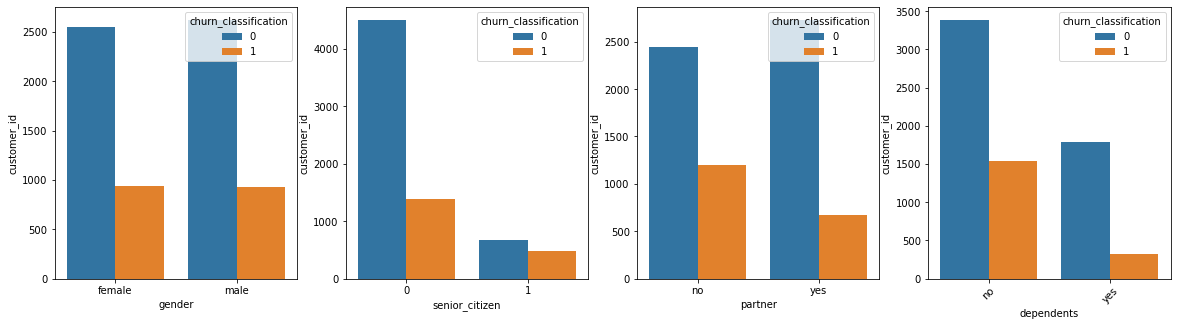

In [24]:
func_pvt(data, personal_cols)

- **Независимо от пола ушедших и текущих клиентов почти равное количество.**
- **Количество ушедших и пользующихся услугами пенсионеров почти одинаковое. Но пенсионеры меньше пользуются услугами**
- **Наличие супругов и иждивенцев. Тех у кого ксть иждивенцы меньше, и отток выше по тем, у кого из нет соответсвенно. Ушедших одиноких вполовину меньше оставшихся, а вот у тех, у кого есть супруги отток ниже.**

,churn_classification,internet_service,customer_id
0,0,dsl,1962
1,0,fiber optic,1799
2,0,no,1413
3,1,dsl,459
4,1,fiber optic,1297
5,1,no,113


,churn_classification,online_security,customer_id
0,0,no,3450
1,0,yes,1724
2,1,no,1574
3,1,yes,295


,churn_classification,online_backup,customer_id
0,0,no,3268
1,0,yes,1906
2,1,no,1346
3,1,yes,523


,churn_classification,device_protection,customer_id
0,0,no,3297
1,0,yes,1877
2,1,no,1324
3,1,yes,545


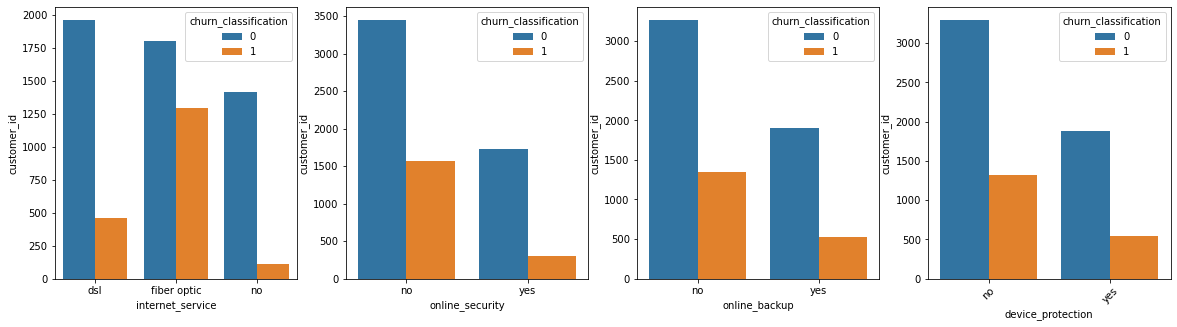

In [25]:
func_pvt(data, add_cols_1)

- **Вид подключения к интернету показывает нам, что больше всего ушедших клиентов пользовались оптоволоконным подключением**
- **Тех, кто не покупал антивирус, использовал резервное копирование и блокировку сайтов больше. Отток в этой категории также выше.**

,churn_classification,tech_support,customer_id
0,0,no,3440
1,0,yes,1734
2,1,no,1559
3,1,yes,310


,churn_classification,streaming_tv,customer_id
0,0,no,3281
1,0,yes,1893
2,1,no,1055
3,1,yes,814


,churn_classification,streaming_movies,customer_id
0,0,no,3260
1,0,yes,1914
2,1,no,1051
3,1,yes,818


,churn_classification,multiple_lines,customer_id
0,0,no,3053
1,0,yes,2121
2,1,no,1019
3,1,yes,850


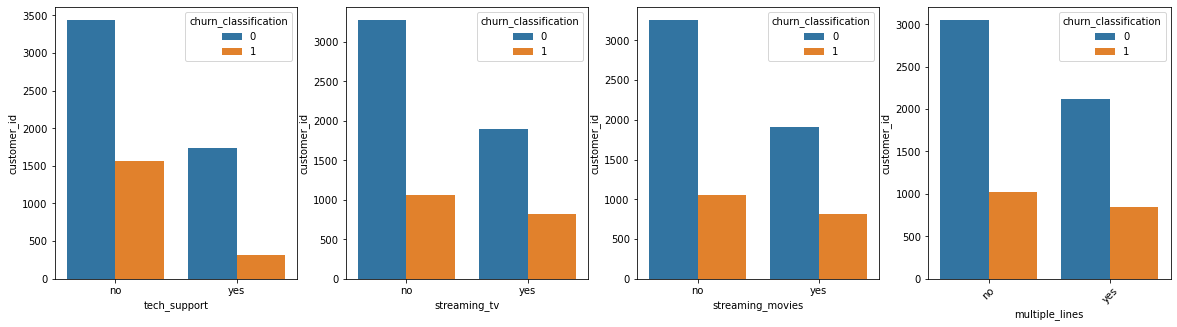

In [26]:
func_pvt(data, add_cols_2)

- **Отток клиентов, использовавших тех. поддержку намного ниже.**
- **Касательно телевидения, фильмов и наличия возможности ведения параллельных линий во время звонка - графики практически идентичны. Тех, кто не пользовался данными услугами больше. А вот ушедших клиентов от 800 до 1000 человек по каждой услуге.**

- Рассмотрим суммы внессеных оплат по типам контрактов.

In [27]:
# создадим сводную для типов и сумм платежей

payment_pvt = data.pivot_table(index=['type'], values=['monthly_charges', 'total_charges'], aggfunc='sum').reset_index()
display(payment_pvt)


,type,monthly_charges,total_charges
0,month-to-month,257294.15,5305861.5
1,one year,95816.60,4467526.3
2,two year,103005.85,6293715.3


**Ежемесячные платежи приносят больший доход по типу month-to-month, но и елиентов выбравших данный тип больше. А вот если смотреть на общие оплаты, больше денег принес тип two year.**

- Посмотрим на промежутки времени. Выясним, как долго и сколько клиентов пользовались услугами.

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn_classification,gender,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,days
2,3668-QPYBK,2019-10-01,2019-12-01,month-to-month,yes,mailed check,53.85,108.15,1,male,...,no,dsl,yes,yes,no,no,no,no,no,61
4,9237-HQITU,2019-09-01,2019-11-01,month-to-month,yes,electronic check,70.70,151.65,1,female,...,no,fiber optic,no,no,no,no,no,no,no,61
5,9305-CDSKC,2019-03-01,2019-11-01,month-to-month,yes,electronic check,99.65,820.50,1,female,...,no,fiber optic,no,no,yes,no,yes,yes,yes,245
8,7892-POOKP,2017-07-01,2019-11-01,month-to-month,yes,electronic check,104.80,3046.05,1,female,...,no,fiber optic,no,no,yes,yes,yes,yes,yes,853
13,0280-XJGEX,2015-09-01,2019-10-01,month-to-month,yes,bank transfer (automatic),103.70,5036.30,1,male,...,no,fiber optic,no,yes,yes,no,yes,yes,yes,1491


,days,customer_id
0,30,182
1,31,198
2,61,123
3,91,31
4,92,63
...,...,...
126,2130,3
127,2132,4
128,2160,5
129,2161,1


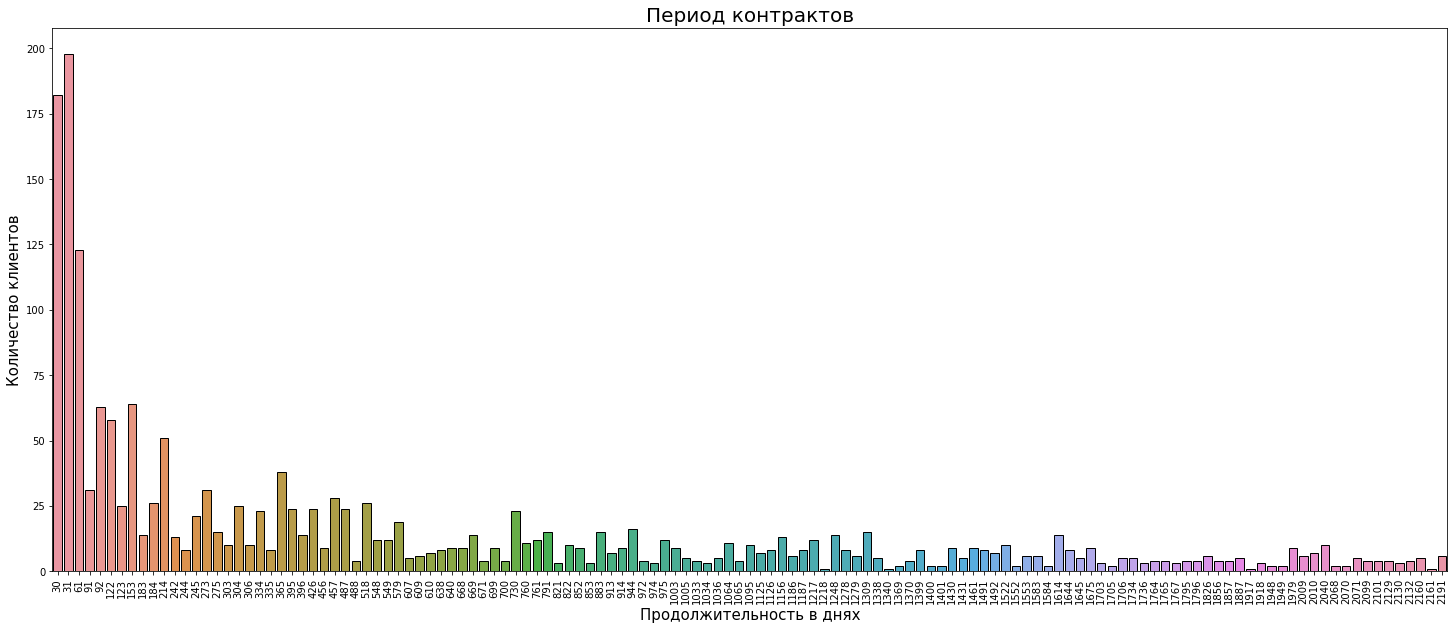

In [28]:
# продолжительность времени
# отфильтруем только тех клиентов, которые ушли
# добьавим столбец с разницой между датами

duration = data[data['end_date'] != 'no']
duration['begin_date'] = pd.to_datetime(duration.begin_date, format='%Y/%m/%d')
duration['end_date'] = pd.to_datetime(duration.end_date, format='%Y/%m/%d')
duration['days'] = (duration['end_date'] - duration['begin_date']).dt.days

display(duration.head())

# создадим сводную

pivot_date = duration.pivot_table(index=['days'], values='customer_id', aggfunc='count').reset_index()
pivot_date = pivot_date.sort_values(by=['days'])
display(pivot_date)

# построим график

plt.figure(figsize=(25,10))

sns.barplot(x='days', y='customer_id', data=pivot_date, ci=0, ec='black')
plt.title('Период контрактов', fontsize=20)
plt.xlabel('Продолжительность в днях', fontsize=15)
plt.ylabel('Количество клиентов', fontsize=15)
plt.xticks(rotation=90)
plt.show()


- **Самый короткий промежуток времени - 30 дней, а самый большой - 2 191.**
- **Виделяются клиенты, которые пользовались услугами компании в течение 1-2 месяцев. Их больше всего. А продолжительность от 5 лет и выше встреячается единично.**
- **Остальные оставались в компании от года до нескольких лет.**

- Посмотрим на год расторжения контракта - в какой год ушло больше клиентов.

,churn_year,customer_id
0,2019,1409
1,2020,460


<AxesSubplot:xlabel='churn_year', ylabel='customer_id'>

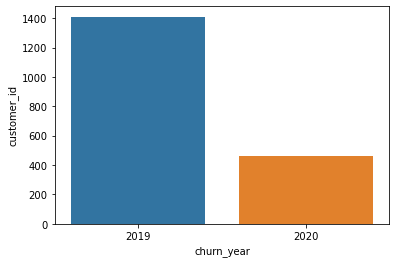

In [29]:
# сделаем еще одну сводную

duration['churn_year'] = duration['end_date'].dt.year

year_pvt = duration.pivot_table(index='churn_year', values='customer_id', aggfunc='count').reset_index()
display(year_pvt)

# построим график

sns.barplot(x='churn_year', y='customer_id', ci=0, data=year_pvt)

**Общий вывод по анализу**

1. Корреляция данных
- Взаимосвязь оттока клиентов имеет очень слабую зависимость от остальных данных, которые у нас есть. Выделяется только взамосвязь между платежами и некоторыми дополнительными услугами.

2. Распределения по платежам, выбросы, влияние типов договора на доход.
- По графику для ежемесячных платежей суммы примерно от 20.00 до 30.00 имеют плотность выше, а по графику для общих сумм клиентов с крупными платежами меньше и они дольше пользовались услугами;
- Выбросов не обнаружено, данные корректные, никаких аномалий нет;
- Ежемесячные платежи приносят больший доход по типу month-to-month, а по общим оплатам, больше денег принес тип two year.

3. Влияние дополнительных услуг, персональных данных и условий контракта на отток
- Те клиенты, которые не используют тех.поддержку, уходят чаще. Также клиентов, которые приобрели тех.поддержку, меньше;
- Тех, кто не пользовался услугами телевидения, фильмов и ведения параллельных линий во время звонка больше.  Ушедших клиентов от 800 (у кого были данные услуги) до 1000 (у кого не было услуг) человек по каждой услуге;
- Вид подключения к интернету показывает нам, что больше всего ушедших клиентов пользовались оптоволоконным подключением;
- Тех, кто не покупал антивирус, использовал резервное копирование и блокировку сайтов больше. Отток в этой категории также выше;
- Независимо от пола ушедших и текущих клиентов почти равное количество. Пенсионеров в таблице меньше а количество ушедших и пользующихся услугами пенсионеров почти одинаковое. Тех у кого есть иждивенцы меньше, и отток выше по тем, у кого их нет соответсвенно. Клиенты, у которых есть супруги отток ниже;
- Клиентов, заключивших помесячный тип контракта, больше. А клиентов, с годичными и двухгодичными договорами почти равное количество. Также ушедших клиентов, которые заключили годичный и двухгодичный контракты, очень мало. Также сильно выделяются те клиенты с помесячным контрактом и опатами электронными чеками.

4. Продолжительность контрактов, год оттока
- У нас всего два года, в которые ушли клиенты - 2019 и 2020. Причем в 2019 году отток был значительнее выше. Это может быть связано с началом пандемии;
- Самый короткий промежуток времени - 30 дней, а самый большой - 2 191. Больше всего клиентов, которые пользовались услугами компании в течение 1-2 месяцев. А продолжительность от 5 лет и выше встречается единично. Остальные оставались в компании от года до нескольких лет.


## Подготовка данных к обучению

- Подготовим наши данные. Преобразуем признаки, выделим целевой признак добавим столбец с разницей между датами и избавимся от ненужных столбцов. Также разделим данные на выборки в пропорциях 3:1:1.

In [33]:
# добавим столбец с продолжительностью пользования услугами
# заменим 'no' на дату выгрузки данных, чтобы посчитать сколько все клиенты пользуются услугами

data['end_date'] = np.where(data.end_date == 'no', datetime.date(2020, 2, 1), data['end_date'])

data['begin_date'] = pd.to_datetime(data.begin_date, format='%Y/%m/%d')
data['end_date'] = pd.to_datetime(data.end_date, format='%Y/%m/%d')
data['days'] = (data['end_date'] - data['begin_date']).dt.days

display(data.head())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn_classification,gender,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,days
0,7590-VHVEG,2020-01-01,2020-02-01,month-to-month,yes,electronic check,29.85,29.85,0,female,...,no,dsl,no,yes,no,no,no,no,no,31
1,5575-GNVDE,2017-04-01,2020-02-01,one year,no,mailed check,56.95,1889.50,0,male,...,no,dsl,yes,no,yes,no,no,no,no,1036
2,3668-QPYBK,2019-10-01,2019-12-01,month-to-month,yes,mailed check,53.85,108.15,1,male,...,no,dsl,yes,yes,no,no,no,no,no,61
3,7795-CFOCW,2016-05-01,2020-02-01,one year,no,bank transfer (automatic),42.30,1840.75,0,male,...,no,dsl,yes,no,yes,yes,no,no,no,1371
4,9237-HQITU,2019-09-01,2019-11-01,month-to-month,yes,electronic check,70.70,151.65,1,female,...,no,fiber optic,no,no,no,no,no,no,no,61


In [34]:
# избавимся от столбцов 'customer_id', 'begin_date', 'end_date' - для дальнейшей работы они нам не нужны

data = data.drop(['customer_id', 'begin_date', 'end_date'], axis=1)
display(data.head())


,type,paperless_billing,payment_method,monthly_charges,total_charges,churn_classification,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,days
0,month-to-month,yes,electronic check,29.85,29.85,0,female,0,yes,no,dsl,no,yes,no,no,no,no,no,31
1,one year,no,mailed check,56.95,1889.50,0,male,0,no,no,dsl,yes,no,yes,no,no,no,no,1036
2,month-to-month,yes,mailed check,53.85,108.15,1,male,0,no,no,dsl,yes,yes,no,no,no,no,no,61
3,one year,no,bank transfer (automatic),42.30,1840.75,0,male,0,no,no,dsl,yes,no,yes,yes,no,no,no,1371
4,month-to-month,yes,electronic check,70.70,151.65,1,female,0,no,no,fiber optic,no,no,no,no,no,no,no,61


In [35]:
# преобразуем категориальные признаки в численные при помощи порядкового кодирования

encoder = OrdinalEncoder()
encoder.fit(data)
data_ordinal = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)

display(data_ordinal)

,type,paperless_billing,payment_method,monthly_charges,total_charges,churn_classification,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,days
0,0.0,1.0,2.0,142.0,74.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
1,1.0,0.0,3.0,498.0,3634.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,74.0
2,0.0,1.0,3.0,436.0,536.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
3,1.0,0.0,0.0,266.0,3580.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,96.0
4,0.0,1.0,2.0,729.0,674.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,1.0,3.0,991.0,3711.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,52.0
7039,1.0,1.0,1.0,1340.0,6315.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,155.0
7040,0.0,1.0,2.0,137.0,1265.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0
7041,0.0,1.0,3.0,795.0,1157.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0


In [46]:
# разделим данные на выборки
# создадим признаки

data_train_x, test = train_test_split(data_ordinal, test_size=0.2, random_state=STATE)
train, valid = train_test_split(data_train_x, test_size=0.25, random_state=STATE)

features_train = train.drop(['churn_classification'], axis=1)
features_valid = valid.drop(['churn_classification'], axis=1)
features_test = test.drop(['churn_classification'], axis=1)

target_train = train['churn_classification']
target_valid = valid['churn_classification']
target_test = test['churn_classification']

print(f'Количество строк в обучающей выборке: {train.shape[0]}')
print(f'Количество строк в валидационной выборке: {valid.shape[0]}')
print(f'Количество строк в тестовой выборке: {test.shape[0]}')

Количество строк в обучающей выборке: 4225
Количество строк в валидационной выборке: 1409
Количество строк в тестовой выборке: 1409


- **Добавили столбец с разницами между датами.**
- **Избавились от ненужных столбцов.**
- **С помощью техники Ordinal Encoding преобразовали категории в числа.**
- **Разделили данные на выборки.**

## Выбор модели машинного обучения

**Цель:**

- Подобрать модель машинного обучения со значением метрики ROC_AUC не ниже 0.85.

Проверим значения метрики обучив несколько моделей:
- LogisticRegression;
- DecisionTreeClassifier;
- RandomForestClassifier;
- CatBoostClassifier
- XGBClassifier.

Обучим модели, выведем AUC_ROC и дополнительно рассчитаем Accuracy.

### LogisticRegression

In [47]:
# обучим модель, выведем AUC_ROC и дополнительно рассчитаем Accuracy

model_log = LogisticRegression(random_state=STATE, solver='liblinear', class_weight='balanced')
model_log.fit(features_train, target_train)
predictions_log = model_log.predict(features_valid)

probabilities_log = model_log.predict_proba(features_valid)
probabilities_one_log = probabilities_log[:, 1]
auc_roc_log = roc_auc_score(target_valid, probabilities_one_log)

print('Accuracy:', accuracy_score(target_valid, predictions_log))
print("AUC_ROC", auc_roc_log)

Accuracy: 0.7409510290986515
AUC_ROC 0.8405863802057455


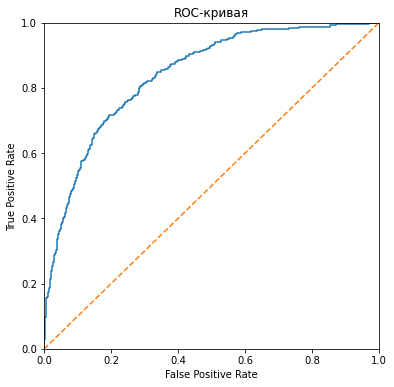

In [48]:
# построим график

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_log)

plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()


### DecisionTreeClassifier

In [49]:
# подберем параметры и лучший показатель метрики с помощью цикла

best_model_tree = None
best_result_tree = 0
for depth in range(1, 16):
    model_tree = DecisionTreeClassifier(random_state=STATE, max_depth=depth, class_weight='balanced')
    model_tree.fit(features_train, target_train)
    predictions_tree = model_tree.predict(features_valid)
    acc_result = accuracy_score(target_valid, predictions_tree)
    
    if acc_result > best_result_tree:
        best_depth = depth
        best_result_tree = model_tree
        best_result_tree = acc_result
        
        probabilities_tree = model_tree.predict_proba(features_valid)
        probabilities_one_tree = probabilities_tree[:, 1]
        auc_roc_tree = roc_auc_score(target_valid, probabilities_one_tree)

print("Глубина:", best_depth)
print('Accuracy:', acc_result)
print("AUC_ROC", auc_roc_tree)

Глубина: 6
Accuracy: 0.7771469127040455
AUC_ROC 0.8233916645311102


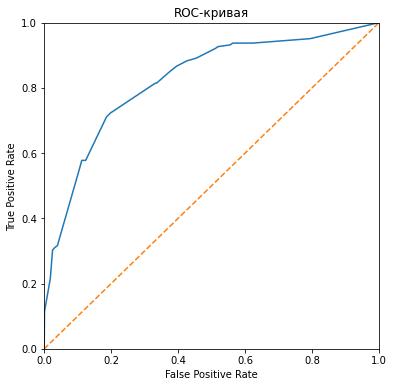

In [50]:
# построим график

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_tree)

plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### RandomForestClassifier

In [51]:
# подберем параметры и лучший показатель метрики с помощью цикла

best_model_forest = None
best_result_forest = 0
for est in range(1, 90, 10):
    for depth in (range(1, 16)):
        model = RandomForestClassifier(random_state=STATE, n_estimators=est, max_depth=depth, class_weight='balanced')
        model.fit(features_train, target_train)
        predictions_forest = model.predict(features_valid)
        acc_result = accuracy_score(target_valid, predictions_forest)

        if acc_result > best_result_forest:
            best_depth = depth
            best_est = est
            best_model_forest = model
            best_result_forest = acc_result
            
            probabilities_forest = model.predict_proba(features_valid)
            probabilities_one_forest = probabilities_forest[:, 1]
            auc_roc_forest = roc_auc_score(target_valid, probabilities_one_forest)
        
print("Глубина:", depth, "Количество деревьев:", est)
print('Accuracy:', acc_result)
print("AUC_ROC", auc_roc_forest)

Глубина: 15 Количество деревьев: 81
Accuracy: 0.8261178140525195
AUC_ROC 0.8418572541800248


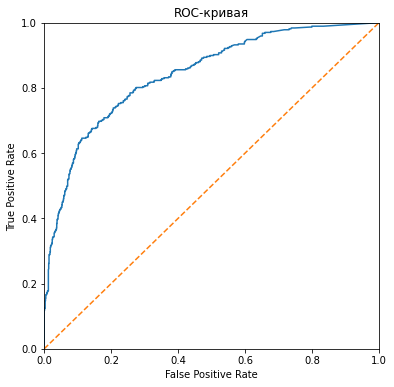

In [52]:
# построим график

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_forest)

plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()


### CatBoostClassifier

In [53]:
# проверим показатели на обучающей выборке

model_cat = CatBoostClassifier(eval_metric='AUC')
model_cat.fit(features_train, target_train, eval_set=(features_valid, target_valid), verbose=False, plot=True);


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [54]:
# выведем показатели

print(model_cat.get_best_score())


{'learn': {'Logloss': 0.14821150649934126}, 'validation': {'Logloss': 0.3459523857412603, 'AUC': 0.8880166521100169}}


In [55]:
# выведем параметры которые использовала наша модель

for key,value in model_cat.get_all_params().items():
 print('{}, {}'.format(key,value))

nan_mode, Min
eval_metric, AUC
iterations, 1000
sampling_frequency, PerTree
leaf_estimation_method, Newton
grow_policy, SymmetricTree
penalties_coefficient, 1
boosting_type, Plain
model_shrink_mode, Constant
feature_border_type, GreedyLogSum
bayesian_matrix_reg, 0.10000000149011612
force_unit_auto_pair_weights, False
l2_leaf_reg, 3
random_strength, 1
rsm, 1
boost_from_average, False
model_size_reg, 0.5
pool_metainfo_options, {'tags': {}}
subsample, 0.800000011920929
use_best_model, True
class_names, [0, 1]
random_seed, 0
depth, 6
posterior_sampling, False
border_count, 254
classes_count, 0
auto_class_weights, None
sparse_features_conflict_fraction, 0
leaf_estimation_backtracking, AnyImprovement
best_model_min_trees, 1
model_shrink_rate, 0
min_data_in_leaf, 1
loss_function, Logloss
learning_rate, 0.045235998928546906
score_function, Cosine
task_type, CPU
leaf_estimation_iterations, 10
bootstrap_type, MVS
max_leaves, 64


### XGBClassifier

In [56]:
# обучим модель и проверим ее качество

model_xgb = xgboost.XGBClassifier(random_state=STATE)
model_xgb.fit(features_train, target_train)

predictions_xgb = model_xgb.predict(features_valid)
accuracy_xgb = accuracy_score(target_valid, predictions_xgb)

probabilities_xgb = model_xgb.predict_proba(features_valid)
probabilities_one_xgb = probabilities_tree[:, 1]
auc_roc_xgb = roc_auc_score(target_valid, probabilities_one_xgb)


print('Accuracy:', accuracy_xgb)
print('AUC_ROC', auc_roc_xgb)

Accuracy: 0.8552164655784245
AUC_ROC 0.8233916645311102


In [57]:
# выведем параметры 

print(model_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1364769524, reg_alpha=0, reg_lambda=1, ...)


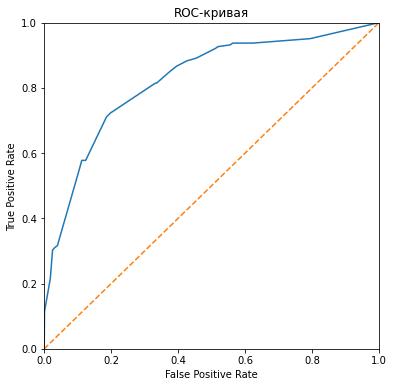

In [58]:
# построим график

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_xgb)

plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()


**ВЫВОД**

В процессе обучения были использованы 5 моделей. Для расчета качества предсказаний взята метрика AUC_ROC.

Сравним показатели метрик каждой модели

1. LogisticRegression
- AUC_ROC - 0.84

2. DecisionTreeClassifier
- AUC_ROC - 0.82

3. RandomForestClassifier
- AUC_ROC - 0.84

4. CatBoostClassifier
- AUC_ROC - 0.88

5. XGBClassifier
- AUC_ROC - 0.81

**Исходя из полученных результатов можно отметить, что для достижения цели данного кейса нам подход CatBoostClassifier. Проверим модель на тестовой выборке.**


## Тестирование модели

In [59]:
# объединим обучающую и валидационную выборки

features_total_train = pd.concat([features_train, features_valid])
target_total_train = pd.concat([target_train, target_valid])

# проверим модель (CatBoostClassifier) на тестовой выборке

model_cat_test = CatBoostClassifier(eval_metric='AUC')
model_cat_test.fit(features_total_train, target_total_train, eval_set=(features_test, target_test), verbose=False, plot=True);

# выведем показатели

print(model_cat_test.get_best_score())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'Logloss': 0.15927390112050002}, 'validation': {'Logloss': 0.3024852085062466, 'AUC': 0.9209733021313001}}


**CatBoostClassifier на тестовой выборке показал значение AUC_ROC - 0.92.**


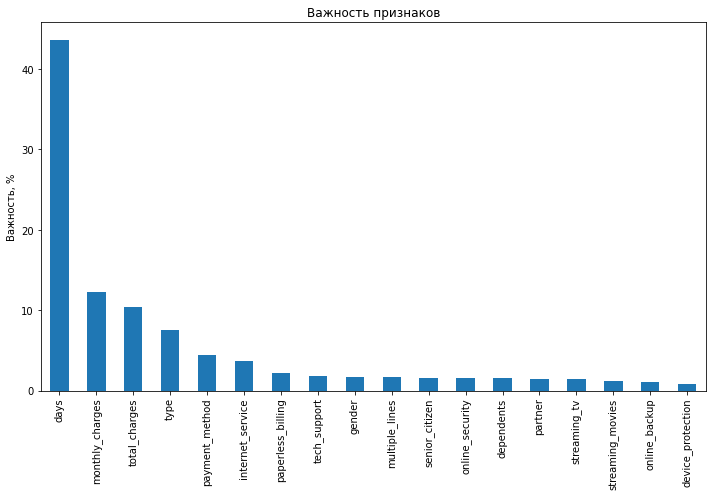

In [60]:
# проведем анализ важности признаков

cat_imp = pd.Series(model_cat_test.get_feature_importance(), features_total_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,7))
cat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

**Вывод**

По итогам работы над проектом можно сказать, что мы решили задачу, поставленную заказчиком. Мы провели анализ данных и обучили модели прогнозировать отток клиентов. Выбрали модель, которая показала лучшее качество.

**CatBoostClassifier на тестовой выборке показал значение AUC_ROC - 0.92.**

Также мы проверили важность признаков и получили такую картину - наивысшую важность на графике показывает признак с продолжительностью дней прибывания клиента в компании, далее можно выделить значимость признаков с оплатами и типами платежей.